In [1]:
import pandas as pd
import numpy as np

In [2]:
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "QLIKE" and crit != "MAD" and crit != "MAPE"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        #for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
        #    is_actual_ok = compiled_regex(str(abs(actual)))
        #    is_pred1_ok = compiled_regex(str(abs(pred1)))
        #    is_pred2_ok = compiled_regex(str(abs(pred2)))
        #    if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):
        #        msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
        #        rt = -1
        #        return (rt,msg)
        return (rt,msg)

    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np

    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []

    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()

    # Length of lists (as real numbers)
    T = float(len(actual_lst))

    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "QLIKE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((abs(actual)/abs(p1)-np.log(abs(actual)/abs(p1))-1))
            e2_lst.append((abs(actual)/abs(p2)-np.log(abs(actual)/abs(p2))-1))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)

    # Mean of d
    mean_d = pd.Series(d_lst).mean()

    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)

    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')

    rt = dm_return(DM = DM_stat, p_value = p_value)

    return DM_stat

In [49]:
GARCH=pd.read_excel("GARCH(1,1)-Norm forecasts.xlsx")#,index_col= "Date")
HAR=pd.read_excel("HAR Forecasts.xlsx")#, index_col= "Date")

In [50]:
NBEATSx=pd.read_excel("NBEATSx forecasts.xlsx")#, index_col= "Date")

In [51]:
NHITS=pd.read_excel("NHITS forecasts.xlsx")#, index_col= "Date")

In [52]:
TFT=pd.read_excel("TFT forecasts.xlsx")#, index_col= "Date")

In [53]:
Actuals=pd.read_excel("Actuals.xlsx")

In [54]:
mask=GARCH['Date'].isin(NBEATSx['Date'])
GARCH=GARCH.loc[mask]

In [55]:
mask=HAR['Date'].isin(GARCH['Date'])
HAR=HAR.loc[mask]

In [56]:
mask=NBEATSx['Date'].isin(GARCH['Date'])
NBEATSx=NBEATSx.loc[mask]

In [57]:
mask=NHITS['Date'].isin(GARCH['Date'])
NHITS=NHITS.loc[mask]

In [58]:
mask=TFT['Date'].isin(GARCH['Date'])
TFT=TFT.loc[mask]

In [59]:
mask=Actuals['Date'].isin(GARCH['Date'])
Actuals=Actuals.loc[mask]

In [60]:
GARCH.set_index('Date',inplace=True)
HAR.set_index('Date',inplace=True)
NBEATSx.set_index('Date',inplace=True)
NHITS.set_index('Date',inplace=True)
TFT.set_index('Date',inplace=True)
Actuals.set_index('Date',inplace=True)

# Error Metrics

RMSE

In [61]:
NHITS_RMSE=(NHITS-Actuals)**2
NBEATSx_RMSE=(NBEATSx-Actuals)**2
TFT_RMSE=(TFT-Actuals)**2
HAR_RMSE=(HAR-Actuals)**2
GARCH_RMSE=(GARCH-Actuals)**2

NHITS_RMSE=np.sqrt(NHITS_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
NBEATSx_RMSE=np.sqrt(NBEATSx_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
TFT_RMSE=np.sqrt(TFT_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
HAR_RMSE=np.sqrt(HAR_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
GARCH_RMSE=np.sqrt(GARCH_RMSE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))

print(f"NHITS RMSE: {NHITS_RMSE}")
print(f"NBEATSx RMSE: {NBEATSx_RMSE}")
print(f"TFT RMSE: {TFT_RMSE}")
print(f"HAR RMSE: {HAR_RMSE}")
print(f"GARCH RMSE: {GARCH_RMSE}")

NHITS RMSE: 0.004800825932346566
NBEATSx RMSE: 0.004765259288673861
TFT RMSE: 0.004849906211836408
HAR RMSE: 0.005026752588138204
GARCH RMSE: 0.005481174624213735


MAE

In [62]:
NHITS_MAE=abs(NHITS-Actuals)
NBEATSx_MAE=abs(NBEATSx-Actuals)
TFT_MAE=abs(TFT-Actuals)
HAR_MAE=abs(HAR-Actuals)
GARCH_MAE=abs(GARCH-Actuals)

NHITS_MAE=(NHITS_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
NBEATSx_MAE=(NBEATSx_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
TFT_MAE=(TFT_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
HAR_MAE=(HAR_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
GARCH_MAE=(GARCH_MAE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))

print(f"NHITS MAE: {NHITS_MAE}")
print(f"NBEATSx MAE: {NBEATSx_MAE}")
print(f"TFT MAE: {TFT_MAE}")
print(f"HAR MAE: {HAR_MAE}")
print(f"GARCH MAE: {GARCH_MAE}")

NHITS MAE: 0.002900406815292433
NBEATSx MAE: 0.0028628182909989854
TFT MAE: 0.0030051142547377367
HAR MAE: 0.0031543013621485112
GARCH MAE: 0.0036267365853942897


QLIKE

In [63]:
NHITS_QLIKE=(Actuals/NHITS)-np.log(Actuals/NHITS)-1
NBEATSx_QLIKE=(Actuals/NBEATSx)-np.log(Actuals/NBEATSx)-1
TFT_QLIKE=(Actuals/TFT)-np.log(Actuals/TFT)-1
HAR_QLIKE=(Actuals/HAR)-np.log(Actuals/HAR)-1
GARCH_QLIKE=(Actuals/GARCH)-np.log(Actuals/GARCH)-1

NHITS_QLIKE=(NHITS_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
NBEATSx_QLIKE=(NBEATSx_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
TFT_QLIKE=(TFT_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
HAR_QLIKE=(HAR_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
GARCH_QLIKE=(GARCH_QLIKE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))

print(f"NHITS QLIKE: {NHITS_QLIKE}")
print(f"NBEATSx QLIKE: {NBEATSx_QLIKE}")
print(f"TFT QLIKE: {TFT_QLIKE}")
print(f"HAR QLIKE: {HAR_QLIKE}")
print(f"GARCH QLIKE: {GARCH_QLIKE}")

NHITS QLIKE: 0.045685657201877526
NBEATSx QLIKE: 0.04506653679510677
TFT QLIKE: 0.04397090387035589
HAR QLIKE: 0.05049075870485081
GARCH QLIKE: 0.057591103317398994


MAPE

In [64]:
NHITS_MAPE=abs(Actuals-NHITS)/Actuals
NBEATSx_MAPE=abs(Actuals-NBEATSx)/Actuals
TFT_MAPE=abs(Actuals-TFT)/Actuals
HAR_MAPE=abs(Actuals-HAR)/Actuals
GARCH_MAPE=abs(Actuals-GARCH)/Actuals

NHITS_MAPE=(NHITS_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
NBEATSx_MAPE=(NBEATSx_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
TFT_MAPE=(TFT_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
HAR_MAPE=(HAR_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))
GARCH_MAPE=(GARCH_MAPE.sum(axis=1).sum(axis=0)/(len(Actuals.columns)*len(Actuals["NKE"])))

print(f"NHITS MAPE: {NHITS_MAPE}")
print(f"NBEATSx MAPE: {NBEATSx_MAPE}")
print(f"TFT MAPE: {TFT_MAPE}")
print(f"HAR MAPE: {HAR_MAPE}")
print(f"GARCH MAPE: {GARCH_MAPE}")

NHITS MAPE: 0.21546205445927832
NBEATSx MAPE: 0.21191740350843136
TFT MAPE: 0.23046674259122393
HAR MAPE: 0.24813601792222548
GARCH MAPE: 0.30754074307


In [65]:
# Creating a dataframe with the error metrics as columns and models as the index
error_metrics_data = {
    'RMSE': [NHITS_RMSE, GARCH_RMSE, HAR_RMSE, TFT_RMSE, NBEATSx_RMSE],
    'MAE': [NHITS_MAE, GARCH_MAE, HAR_MAE, TFT_MAE, NBEATSx_MAE],
    'MAPE': [NHITS_MAPE, GARCH_MAPE, HAR_MAPE, TFT_MAPE, NBEATSx_MAPE],
    'QLIKE': [NHITS_QLIKE, GARCH_QLIKE, HAR_QLIKE, TFT_QLIKE, NBEATSx_QLIKE]
}

models = ['NHITS', 'GARCH', 'HAR',  'TFT', 'NBEATSx']

# Create the DataFrame
error_metrics_df = pd.DataFrame(data=error_metrics_data, index=models)

error_metrics_df

,RMSE,MAE,MAPE,QLIKE
NHITS,0.004801,0.002900,0.215462,0.045686
GARCH,0.005481,0.003627,0.307541,0.057591
HAR,0.005027,0.003154,0.248136,0.050491
TFT,0.004850,0.003005,0.230467,0.043971
NBEATSx,0.004765,0.002863,0.211917,0.045067


In [ ]:
error_metrics_df.to_excel("Error Metrics.xlsx")

# DM tests with MSE

In [66]:
Stocks = []
for i in range(len(NHITS.columns)):
  Stocks.append(NHITS.columns[i])


If DM_stat is negative, first model is better, otherwise second one is better

In [67]:
DM_statistics_NBEATSx_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_NBEATSx_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], NBEATSx[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MSE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than NBEATSx: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than NBEATSx:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_NBEATSx_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_NHITS<-1.96)[0])):
  Stocks_where_NBEATSx_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where NBEATSx yields statistically significant better forecasts than NHITS: {len(Stocks_where_NBEATSx_is_statistically_better)}")
print(f"Stocks where NBEATSx yields statistically significant better forecasts than NHITS:")
print(Stocks_where_NBEATSx_is_statistically_better)
NHITS_better_NBEATSx=len(Stocks_where_NHITS_is_statistically_better)
NBEATSx_better_NHITS=len(Stocks_where_NBEATSx_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than NBEATSx: 1
Stocks where NHITS yields statistically significant better forecasts than NBEATSx:
['AMZN']
Number of stocks where NBEATSx yields statistically significant better forecasts than NHITS: 13
Stocks where NBEATSx yields statistically significant better forecasts than NHITS:
['ADBE', 'BAC', 'BMY', 'C', 'COST', 'CVX', 'DHR', 'DIS', 'FISV', 'GILD', 'JPM', 'LOW', 'WFC']


In [68]:
DM_statistics_HAR_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_HAR_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], HAR[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MSE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than HAR: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than HAR:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_HAR_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_NHITS<-1.96)[0])):
  Stocks_where_HAR_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where HAR yields statistically significant better forecasts than NHITS: {len(Stocks_where_HAR_is_statistically_better)}")
print(f"Stocks where HAR yields statistically significant better forecasts than NHITS:")
print(Stocks_where_HAR_is_statistically_better)
NHITS_better_HAR=len(Stocks_where_NHITS_is_statistically_better)
HAR_better_NHITS=len(Stocks_where_HAR_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than HAR: 21
Stocks where NHITS yields statistically significant better forecasts than HAR:
['AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BSX', 'C', 'CI', 'CME', 'CRM', 'CVS', 'GE', 'JPM', 'MO', 'MS', 'NFLX', 'NVDA', 'SBUX', 'TGT', 'UNH', 'VZ']
Number of stocks where HAR yields statistically significant better forecasts than NHITS: 4
Stocks where HAR yields statistically significant better forecasts than NHITS:
['BMY', 'LOW', 'NKE', 'TJX']


In [69]:
DM_statistics_TFT_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_TFT_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], TFT[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MSE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than TFT: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than TFT:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_TFT_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_NHITS<-1.96)[0])):
  Stocks_where_TFT_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where TFT yields statistically significant better forecasts than NHITS: {len(Stocks_where_TFT_is_statistically_better)}")
print(f"Stocks where TFT yields statistically significant better forecasts than NHITS:")
print(Stocks_where_TFT_is_statistically_better)
NHITS_better_TFT=len(Stocks_where_NHITS_is_statistically_better)
TFT_better_NHITS=len(Stocks_where_TFT_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than TFT: 1
Stocks where NHITS yields statistically significant better forecasts than TFT:
['AMZN']
Number of stocks where TFT yields statistically significant better forecasts than NHITS: 0
Stocks where TFT yields statistically significant better forecasts than NHITS:
[]


In [70]:
DM_statistics_GARCH_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_GARCH_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], GARCH[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MSE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_GARCH_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_GARCH_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than GARCH: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than GARCH:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_GARCH_is_statistically_better = []
for i in range(len(np.where(DM_statistics_GARCH_vs_NHITS<-1.96)[0])):
  Stocks_where_GARCH_is_statistically_better.append(Stocks[np.where(DM_statistics_GARCH_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where GARCH yields statistically significant better forecasts than NHITS: {len(Stocks_where_GARCH_is_statistically_better)}")
print(f"Stocks where GARCH yields statistically significant better forecasts than NHITS:")
print(Stocks_where_GARCH_is_statistically_better)
NHITS_better_GARCH=len(Stocks_where_NHITS_is_statistically_better)
GARCH_better_NHITS=len(Stocks_where_GARCH_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than GARCH: 68
Stocks where NHITS yields statistically significant better forecasts than GARCH:
['ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HON', 'INTC', 'INTU', 'ISRG', 'JPM', 'LLY', 'LMT', 'LOW', 'MA', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PFE', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WMT']
Number of stocks where GARCH yields statistically significant better forecasts than NHITS: 0
Stocks where GARCH yields statistically significant better forecasts than NHITS:
[]


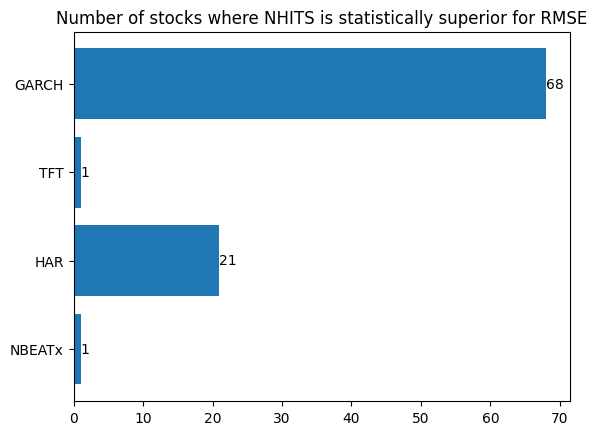

In [71]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["NBEATx", "HAR", "TFT", "GARCH"])
y = np.array([NHITS_better_NBEATSx, NHITS_better_HAR, NHITS_better_TFT, NHITS_better_GARCH])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where NHITS is statistically superior for RMSE")
plt.show()

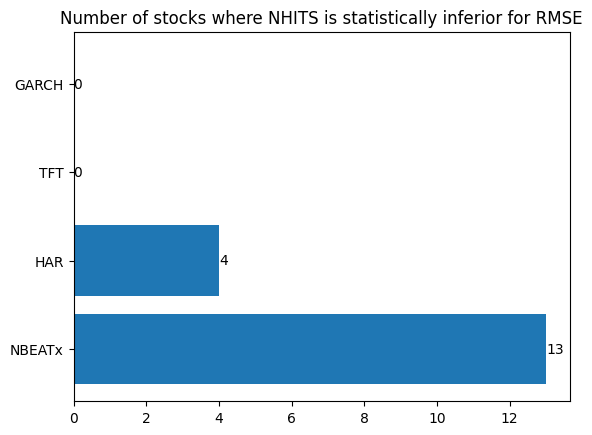

In [72]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["NBEATx", "HAR", "TFT", "GARCH"])
y = np.array([NBEATSx_better_NHITS, HAR_better_NHITS, TFT_better_NHITS, GARCH_better_NHITS])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where NHITS is statistically inferior for RMSE")
plt.show()

# DM tests with MAE

In [73]:
DM_statistics_NBEATSx_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_NBEATSx_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], NBEATSx[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MAD")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than NBEATSx: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than NBEATSx:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_NBEATSx_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_NHITS<-1.96)[0])):
  Stocks_where_NBEATSx_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where NBEATSx yields statistically significant better forecasts than NHITS: {len(Stocks_where_NBEATSx_is_statistically_better)}")
print(f"Stocks where NBEATSx yields statistically significant better forecasts than NHITS:")
print(Stocks_where_NBEATSx_is_statistically_better)
NHITS_better_NBEATSx=len(Stocks_where_NHITS_is_statistically_better)
NBEATSx_better_NHITS=len(Stocks_where_NBEATSx_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than NBEATSx: 0
Stocks where NHITS yields statistically significant better forecasts than NBEATSx:
[]
Number of stocks where NBEATSx yields statistically significant better forecasts than NHITS: 33
Stocks where NBEATSx yields statistically significant better forecasts than NHITS:
['ABT', 'ADBE', 'AMT', 'AXP', 'BAC', 'BMY', 'C', 'CI', 'DHR', 'DIS', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'INTU', 'ISRG', 'JPM', 'LMT', 'LOW', 'MA', 'MCD', 'MMM', 'MO', 'MS', 'MSFT', 'NVDA', 'PEP', 'PFE', 'PNC', 'UNH', 'USB']


In [74]:
DM_statistics_HAR_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_HAR_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], HAR[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MAD")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than HAR: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than HAR:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_HAR_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_NHITS<-1.96)[0])):
  Stocks_where_HAR_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where HAR yields statistically significant better forecasts than NHITS: {len(Stocks_where_HAR_is_statistically_better)}")
print(f"Stocks where HAR yields statistically significant better forecasts than NHITS:")
print(Stocks_where_HAR_is_statistically_better)
NHITS_better_HAR=len(Stocks_where_NHITS_is_statistically_better)
HAR_better_NHITS=len(Stocks_where_HAR_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than HAR: 40
Stocks where NHITS yields statistically significant better forecasts than HAR:
['AAPL', 'ACN', 'AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BSX', 'C', 'CI', 'CMCSA', 'CME', 'COST', 'CRM', 'CSCO', 'CVS', 'GE', 'GILD', 'GS', 'HD', 'HON', 'ISRG', 'JPM', 'MA', 'MO', 'MRK', 'MS', 'NFLX', 'NVDA', 'ORCL', 'PNC', 'SBUX', 'T', 'TGT', 'TXN', 'UNH', 'UNP', 'USB', 'VZ', 'WFC']
Number of stocks where HAR yields statistically significant better forecasts than NHITS: 6
Stocks where HAR yields statistically significant better forecasts than NHITS:
['ABT', 'BMY', 'DIS', 'KO', 'MCD', 'WMT']


In [75]:
DM_statistics_TFT_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_TFT_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], TFT[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MAD")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than TFT: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than TFT:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_TFT_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_NHITS<-1.96)[0])):
  Stocks_where_TFT_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where TFT yields statistically significant better forecasts than NHITS: {len(Stocks_where_TFT_is_statistically_better)}")
print(f"Stocks where TFT yields statistically significant better forecasts than NHITS:")
print(Stocks_where_TFT_is_statistically_better)
NHITS_better_TFT=len(Stocks_where_NHITS_is_statistically_better)
TFT_better_NHITS=len(Stocks_where_TFT_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than TFT: 62
Stocks where NHITS yields statistically significant better forecasts than TFT:
['AAPL', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DIS', 'GE', 'GILD', 'GOOG', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'JNJ', 'KO', 'LLY', 'LMT', 'MA', 'MDT', 'MMM', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'QCOM', 'SBUX', 'SYK', 'T', 'TGT', 'TJX', 'TXN', 'UPS', 'VZ', 'WFC', 'WMT']
Number of stocks where TFT yields statistically significant better forecasts than NHITS: 0
Stocks where TFT yields statistically significant better forecasts than NHITS:
[]


In [76]:
DM_statistics_GARCH_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_GARCH_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], GARCH[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MAD")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_GARCH_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_GARCH_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than GARCH: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than GARCH:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_GARCH_is_statistically_better = []
for i in range(len(np.where(DM_statistics_GARCH_vs_NHITS<-1.96)[0])):
  Stocks_where_GARCH_is_statistically_better.append(Stocks[np.where(DM_statistics_GARCH_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where GARCH yields statistically significant better forecasts than NHITS: {len(Stocks_where_GARCH_is_statistically_better)}")
print(f"Stocks where GARCH yields statistically significant better forecasts than NHITS:")
print(Stocks_where_GARCH_is_statistically_better)
NHITS_better_GARCH=len(Stocks_where_NHITS_is_statistically_better)
GARCH_better_NHITS=len(Stocks_where_GARCH_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than GARCH: 80
Stocks where NHITS yields statistically significant better forecasts than GARCH:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']
Number of stocks where GARCH yields statistically significant better forecasts than NHITS: 0
Stocks where GARCH yields statistically significant better forecasts than NHITS:
[]


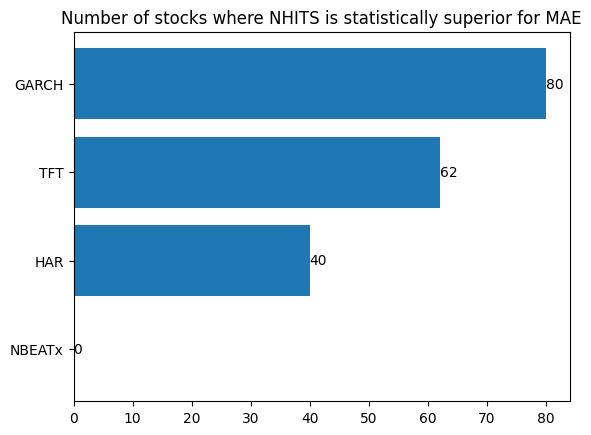

In [77]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["NBEATx", "HAR", "TFT", "GARCH"])
y = np.array([NHITS_better_NBEATSx, NHITS_better_HAR, NHITS_better_TFT, NHITS_better_GARCH])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where NHITS is statistically superior for MAE")
plt.show()

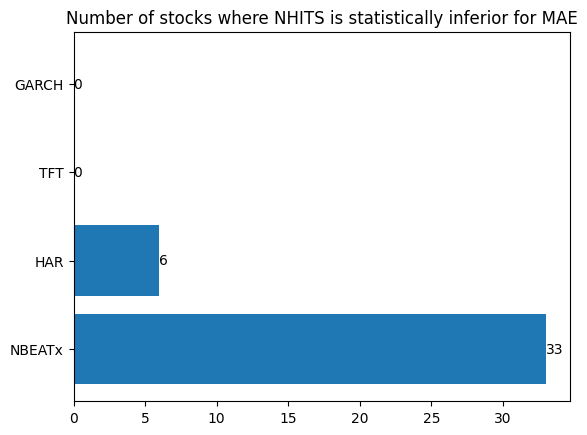

In [78]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["NBEATx", "HAR", "TFT", "GARCH"])
y = np.array([NBEATSx_better_NHITS, HAR_better_NHITS, TFT_better_NHITS, GARCH_better_NHITS])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where NHITS is statistically inferior for MAE")
plt.show()

# DM tests with QLIKE

In [79]:
DM_statistics_NBEATSx_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_NBEATSx_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], NBEATSx[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="QLIKE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than NBEATSx: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than NBEATSx:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_NBEATSx_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_NHITS<-1.96)[0])):
  Stocks_where_NBEATSx_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where NBEATSx yields statistically significant better forecasts than NHITS: {len(Stocks_where_NBEATSx_is_statistically_better)}")
print(f"Stocks where NBEATSx yields statistically significant better forecasts than NHITS:")
print(Stocks_where_NBEATSx_is_statistically_better)
NHITS_better_NBEATSx=len(Stocks_where_NHITS_is_statistically_better)
NBEATSx_better_NHITS=len(Stocks_where_NBEATSx_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than NBEATSx: 4
Stocks where NHITS yields statistically significant better forecasts than NBEATSx:
['AMZN', 'BA', 'D', 'ISRG']
Number of stocks where NBEATSx yields statistically significant better forecasts than NHITS: 22
Stocks where NBEATSx yields statistically significant better forecasts than NHITS:
['AAPL', 'BMY', 'C', 'CAT', 'CB', 'CI', 'CME', 'COP', 'COST', 'CVS', 'CVX', 'FISV', 'HD', 'IBM', 'MS', 'MSFT', 'PEP', 'PG', 'PNC', 'QCOM', 'SO', 'TXN']


In [80]:
DM_statistics_HAR_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_HAR_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], HAR[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="QLIKE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than HAR: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than HAR:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_HAR_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_NHITS<-1.96)[0])):
  Stocks_where_HAR_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where HAR yields statistically significant better forecasts than NHITS: {len(Stocks_where_HAR_is_statistically_better)}")
print(f"Stocks where HAR yields statistically significant better forecasts than NHITS:")
print(Stocks_where_HAR_is_statistically_better)
NHITS_better_HAR=len(Stocks_where_NHITS_is_statistically_better)
HAR_better_NHITS=len(Stocks_where_HAR_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than HAR: 27
Stocks where NHITS yields statistically significant better forecasts than HAR:
['ADP', 'AMZN', 'AXP', 'BA', 'BDX', 'BSX', 'CB', 'CI', 'CME', 'COP', 'CRM', 'CVS', 'FISV', 'GE', 'JNJ', 'MMM', 'MO', 'MS', 'MSFT', 'NFLX', 'QCOM', 'SBUX', 'SO', 'TGT', 'UNH', 'UPS', 'VZ']
Number of stocks where HAR yields statistically significant better forecasts than NHITS: 2
Stocks where HAR yields statistically significant better forecasts than NHITS:
['BMY', 'NKE']


In [81]:
DM_statistics_TFT_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_TFT_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], TFT[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="QLIKE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than TFT: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than TFT:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_TFT_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_NHITS<-1.96)[0])):
  Stocks_where_TFT_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where TFT yields statistically significant better forecasts than NHITS: {len(Stocks_where_TFT_is_statistically_better)}")
print(f"Stocks where TFT yields statistically significant better forecasts than NHITS:")
print(Stocks_where_TFT_is_statistically_better)
NHITS_better_TFT=len(Stocks_where_NHITS_is_statistically_better)
TFT_better_NHITS=len(Stocks_where_TFT_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than TFT: 0
Stocks where NHITS yields statistically significant better forecasts than TFT:
[]
Number of stocks where TFT yields statistically significant better forecasts than NHITS: 44
Stocks where TFT yields statistically significant better forecasts than NHITS:
['AAPL', 'ABT', 'ACN', 'ADBE', 'BAC', 'BMY', 'C', 'CAT', 'CB', 'CI', 'COP', 'COST', 'CRM', 'CVX', 'DHR', 'DUK', 'FISV', 'GE', 'GOOG', 'GS', 'HD', 'IBM', 'INTC', 'INTU', 'JNJ', 'JPM', 'MCD', 'MO', 'MS', 'MSFT', 'NFLX', 'NVDA', 'PEP', 'PG', 'PNC', 'QCOM', 'SO', 'TJX', 'TMO', 'TXN', 'UNH', 'UPS', 'USB', 'WFC']


In [82]:
DM_statistics_GARCH_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_GARCH_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], GARCH[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="QLIKE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_GARCH_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_GARCH_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than GARCH: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than GARCH:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_GARCH_is_statistically_better = []
for i in range(len(np.where(DM_statistics_GARCH_vs_NHITS<-1.96)[0])):
  Stocks_where_GARCH_is_statistically_better.append(Stocks[np.where(DM_statistics_GARCH_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where GARCH yields statistically significant better forecasts than NHITS: {len(Stocks_where_GARCH_is_statistically_better)}")
print(f"Stocks where GARCH yields statistically significant better forecasts than NHITS:")
print(Stocks_where_GARCH_is_statistically_better)
NHITS_better_GARCH=len(Stocks_where_NHITS_is_statistically_better)
GARCH_better_NHITS=len(Stocks_where_GARCH_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than GARCH: 77
Stocks where NHITS yields statistically significant better forecasts than GARCH:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']
Number of stocks where GARCH yields statistically significant better forecasts than NHITS: 0
Stocks where GARCH yields statistically significant better forecasts than NHITS:
[]


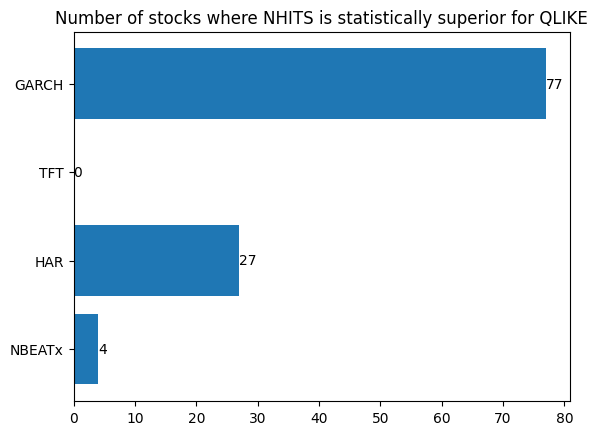

In [84]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["NBEATx", "HAR", "TFT", "GARCH"])
y = np.array([NHITS_better_NBEATSx, NHITS_better_HAR, NHITS_better_TFT,NHITS_better_GARCH])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where NHITS is statistically superior for QLIKE")
plt.show()

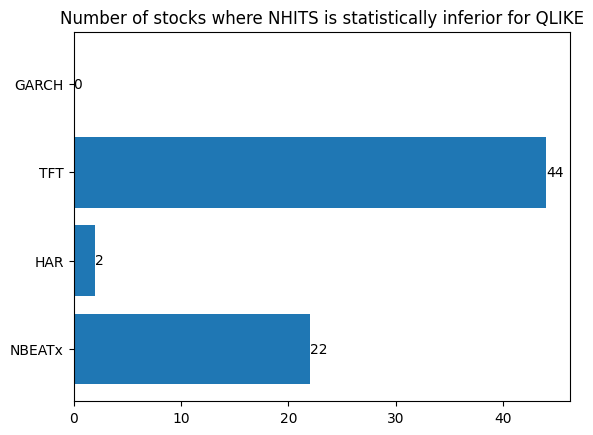

In [85]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["NBEATx", "HAR", "TFT", "GARCH"])
y = np.array([NBEATSx_better_NHITS, HAR_better_NHITS, TFT_better_NHITS, GARCH_better_NHITS])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where NHITS is statistically inferior for QLIKE")
plt.show()

# DM tests with MAPE

In [86]:
DM_statistics_NBEATSx_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_NBEATSx_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], NBEATSx[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MAPE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than NBEATSx: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than NBEATSx:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_NBEATSx_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_NHITS<-1.96)[0])):
  Stocks_where_NBEATSx_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where NBEATSx yields statistically significant better forecasts than NHITS: {len(Stocks_where_NBEATSx_is_statistically_better)}")
print(f"Stocks where NBEATSx yields statistically significant better forecasts than NHITS:")
print(Stocks_where_NBEATSx_is_statistically_better)
NHITS_better_NBEATSx=len(Stocks_where_NHITS_is_statistically_better)
NBEATSx_better_NHITS=len(Stocks_where_NBEATSx_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than NBEATSx: 6
Stocks where NHITS yields statistically significant better forecasts than NBEATSx:
['AMGN', 'COP', 'CSCO', 'INTC', 'KO', 'ORCL']
Number of stocks where NBEATSx yields statistically significant better forecasts than NHITS: 39
Stocks where NBEATSx yields statistically significant better forecasts than NHITS:
['ABT', 'ACN', 'AMT', 'AMZN', 'AXP', 'BAC', 'BMY', 'BSX', 'C', 'CB', 'CI', 'CME', 'D', 'DIS', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HON', 'INTU', 'ISRG', 'JPM', 'LMT', 'LOW', 'MA', 'MCD', 'MMM', 'MO', 'MSFT', 'NVDA', 'PEP', 'PFE', 'PNC', 'UNH', 'USB', 'VZ', 'WMT']


In [87]:
DM_statistics_HAR_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_HAR_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], HAR[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MAPE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than HAR: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than HAR:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_HAR_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_NHITS<-1.96)[0])):
  Stocks_where_HAR_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where HAR yields statistically significant better forecasts than NHITS: {len(Stocks_where_HAR_is_statistically_better)}")
print(f"Stocks where HAR yields statistically significant better forecasts than NHITS:")
print(Stocks_where_HAR_is_statistically_better)
NHITS_better_HAR=len(Stocks_where_NHITS_is_statistically_better)
HAR_better_NHITS=len(Stocks_where_HAR_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than HAR: 49
Stocks where NHITS yields statistically significant better forecasts than HAR:
['AAPL', 'ACN', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BAC', 'BSX', 'C', 'CAT', 'CI', 'CMCSA', 'CME', 'COST', 'CRM', 'CSCO', 'CVX', 'DHR', 'DUK', 'FIS', 'GE', 'GILD', 'GS', 'HD', 'HON', 'INTC', 'ISRG', 'JPM', 'LOW', 'MA', 'MDT', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PFE', 'PNC', 'SBUX', 'T', 'TGT', 'TXN', 'UNH', 'UNP', 'USB', 'VZ', 'WFC']
Number of stocks where HAR yields statistically significant better forecasts than NHITS: 8
Stocks where HAR yields statistically significant better forecasts than NHITS:
['ABT', 'ADP', 'FISV', 'INTU', 'JNJ', 'MCD', 'PEP', 'WMT']


In [88]:
DM_statistics_TFT_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_TFT_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], TFT[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MAPE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than TFT: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than TFT:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_TFT_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_NHITS<-1.96)[0])):
  Stocks_where_TFT_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where TFT yields statistically significant better forecasts than NHITS: {len(Stocks_where_TFT_is_statistically_better)}")
print(f"Stocks where TFT yields statistically significant better forecasts than NHITS:")
print(Stocks_where_TFT_is_statistically_better)
NHITS_better_TFT=len(Stocks_where_NHITS_is_statistically_better)
TFT_better_NHITS=len(Stocks_where_TFT_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than TFT: 79
Stocks where NHITS yields statistically significant better forecasts than TFT:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'MA', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']
Number of stocks where TFT yields statistically significant better forecasts than NHITS: 0
Stocks where TFT yields statistically significant better forecasts than NHITS:
[]


In [89]:
DM_statistics_GARCH_vs_NHITS = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_GARCH_vs_NHITS[i]=dm_test(Actuals[Stocks[i]], GARCH[Stocks[i]], NHITS[Stocks[i]], h = 1, crit="MAPE")

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_GARCH_vs_NHITS>1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_GARCH_vs_NHITS>1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than GARCH: {len(Stocks_where_NHITS_is_statistically_better)}")
print("Stocks where NHITS yields statistically significant better forecasts than GARCH:")
print(Stocks_where_NHITS_is_statistically_better)

Stocks_where_GARCH_is_statistically_better = []
for i in range(len(np.where(DM_statistics_GARCH_vs_NHITS<-1.96)[0])):
  Stocks_where_GARCH_is_statistically_better.append(Stocks[np.where(DM_statistics_GARCH_vs_NHITS<-1.96)[0][i]])

print(f"Number of stocks where GARCH yields statistically significant better forecasts than NHITS: {len(Stocks_where_GARCH_is_statistically_better)}")
print(f"Stocks where GARCH yields statistically significant better forecasts than NHITS:")
print(Stocks_where_GARCH_is_statistically_better)
NHITS_better_GARCH=len(Stocks_where_NHITS_is_statistically_better)
GARCH_better_NHITS=len(Stocks_where_GARCH_is_statistically_better)

Number of stocks where NHITS yields statistically significant better forecasts than GARCH: 80
Stocks where NHITS yields statistically significant better forecasts than GARCH:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']
Number of stocks where GARCH yields statistically significant better forecasts than NHITS: 0
Stocks where GARCH yields statistically significant better forecasts than NHITS:
[]


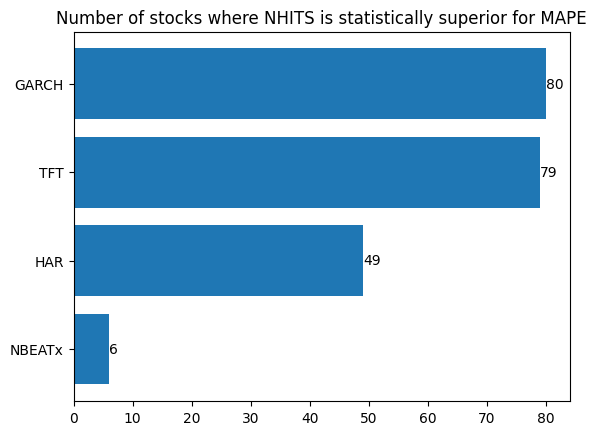

In [90]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["NBEATx", "HAR", "TFT", "GARCH"])
y = np.array([NHITS_better_NBEATSx, NHITS_better_HAR, NHITS_better_TFT, NHITS_better_GARCH])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where NHITS is statistically superior for MAPE")
plt.show()

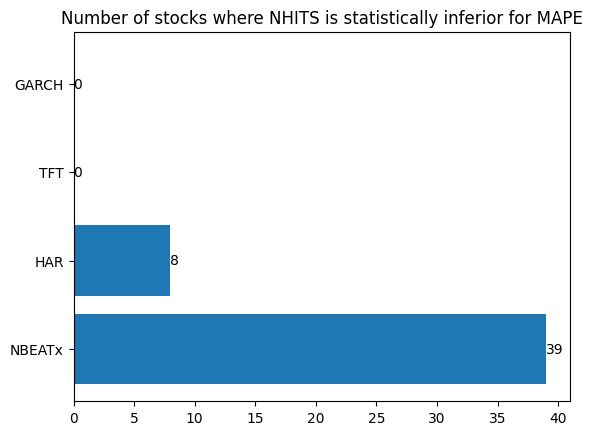

In [91]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["NBEATx", "HAR", "TFT", "GARCH"])
y = np.array([NBEATSx_better_NHITS, HAR_better_NHITS, TFT_better_NHITS,GARCH_better_NHITS])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where NHITS is statistically inferior for MAPE")
plt.show()

# MCS test with MSE

In [92]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 12.5 MB/s eta 0:00:00


In [93]:
from arch.bootstrap import MCS

Alphabetic Order: GARCH, HAR, NBEATSx, NHITS, TFT

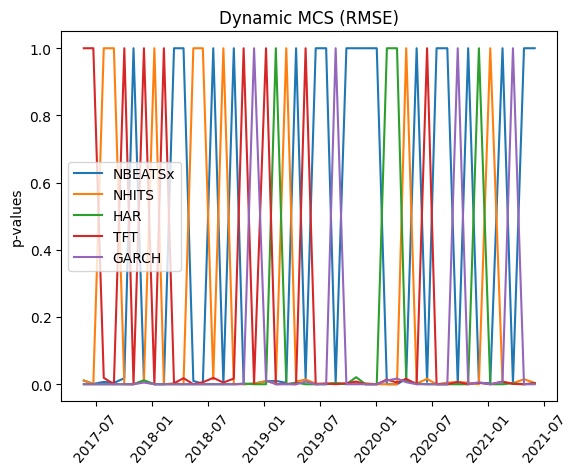

In [95]:
NHITS_residuals=(NHITS-Actuals)**2
NBEATSx_residuals=(NBEATSx-Actuals)**2
TFT_residuals=(TFT-Actuals)**2
HAR_residuals=(HAR-Actuals)**2
GARCH_residuals=(GARCH-Actuals)**2

NHITS_residuals=NHITS_residuals.sum(axis=1)/len(Actuals.columns)
NBEATSx_residuals=NBEATSx_residuals.sum(axis=1)/len(Actuals.columns)
TFT_residuals=TFT_residuals.sum(axis=1)/len(Actuals.columns)
HAR_residuals=HAR_residuals.sum(axis=1)/len(Actuals.columns)
GARCH_residuals=GARCH_residuals.sum(axis=1)/len(Actuals.columns)

losses = pd.DataFrame({'NHITS':NHITS_residuals,
              'NBEATSx': NBEATSx_residuals,
              'TFT': TFT_residuals,
              'HAR': HAR_residuals,
              'GARCH': GARCH_residuals})

losses=losses.iloc[:len(losses)-len(losses)%22]
periods=[]
for i in range(int(len(losses)/22)+1):
  periods.append(22*i)

Dynamic_pvalues=np.zeros([int(len(losses)/22),5])
for i in range(len(periods)-1):
  mcs = MCS(losses.iloc[periods[i]:periods[i+1]], size=0.05, method="R", block_size=len(losses))
  mcs.compute()
  Dynamic_pvalues[i,:]=mcs.pvalues.sort_values('Model name').values.reshape(5)

Indexes=np.zeros([int(len(losses)/22),1])
for i in range(len(periods)-1):
  df2=losses.iloc[periods[i]:periods[i+1]]
  Indexes[i,:]=df2.index.values[-1]
Indexes=Indexes.reshape(len(Dynamic_pvalues)).astype('datetime64[ns]')
Data= {'GARCH':Dynamic_pvalues[:,0],
       'HAR':Dynamic_pvalues[:,1],
       'NBEATSx':Dynamic_pvalues[:,2],
       'NHITS':Dynamic_pvalues[:,3],
       'TFT':Dynamic_pvalues[:,4]

}

Pvalues=pd.DataFrame(data=Data, index=Indexes )

plt.plot(Pvalues.index,Pvalues["NBEATSx"])
plt.plot(Pvalues.index,Pvalues["NHITS"])
plt.plot(Pvalues.index,Pvalues["HAR"])
plt.plot(Pvalues.index,Pvalues["TFT"])
plt.plot(Pvalues.index,Pvalues["GARCH"])
plt.ylabel("p-values")
plt.title("Dynamic MCS (RMSE)")
plt.legend(['NBEATSx', 'NHITS', 'HAR', 'TFT', 'GARCH'])
plt.xticks(rotation=50)
plt.show()

# MCS test with MAE

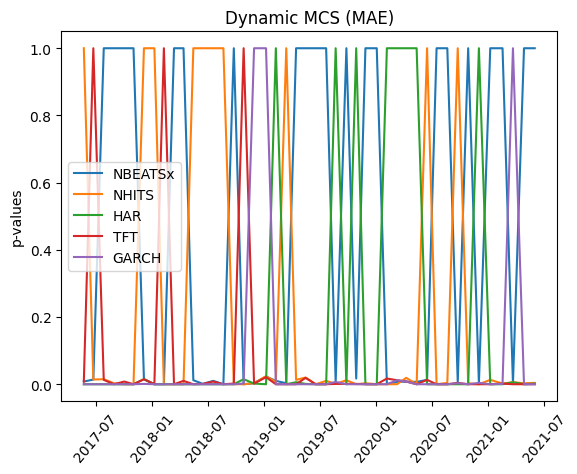

In [96]:
NHITS_residuals=abs(NHITS-Actuals)
NBEATSx_residuals=abs(NBEATSx-Actuals)
TFT_residuals=abs(TFT-Actuals)
HAR_residuals=abs(HAR-Actuals)
GARCH_residuals=abs(GARCH-Actuals)

NHITS_residuals=NHITS_residuals.sum(axis=1)/len(Actuals.columns)
NBEATSx_residuals=NBEATSx_residuals.sum(axis=1)/len(Actuals.columns)
TFT_residuals=TFT_residuals.sum(axis=1)/len(Actuals.columns)
HAR_residuals=HAR_residuals.sum(axis=1)/len(Actuals.columns)
GARCH_residuals=GARCH_residuals.sum(axis=1)/len(Actuals.columns)

losses = pd.DataFrame({'NHITS':NHITS_residuals,
              'NBEATSx': NBEATSx_residuals,
              'TFT': TFT_residuals,
              'HAR': HAR_residuals,
              'GARCH': GARCH_residuals})

losses=losses.iloc[:len(losses)-len(losses)%22]
periods=[]
for i in range(int(len(losses)/22)+1):
  periods.append(22*i)

Dynamic_pvalues=np.zeros([int(len(losses)/22),5])
for i in range(len(periods)-1):
  mcs = MCS(losses.iloc[periods[i]:periods[i+1]], size=0.05, method="R", block_size=len(losses))
  mcs.compute()
  Dynamic_pvalues[i,:]=mcs.pvalues.sort_values('Model name').values.reshape(5)

Indexes=np.zeros([int(len(losses)/22),1])
for i in range(len(periods)-1):
  df2=losses.iloc[periods[i]:periods[i+1]]
  Indexes[i,:]=df2.index.values[-1]
Indexes=Indexes.reshape(len(Dynamic_pvalues)).astype('datetime64[ns]')
Data= {'GARCH':Dynamic_pvalues[:,0],
       'HAR':Dynamic_pvalues[:,1],
       'NBEATSx':Dynamic_pvalues[:,2],
       'NHITS':Dynamic_pvalues[:,3],
       'TFT':Dynamic_pvalues[:,4]

}

Pvalues=pd.DataFrame(data=Data, index=Indexes )

plt.plot(Pvalues.index,Pvalues["NBEATSx"])
plt.plot(Pvalues.index,Pvalues["NHITS"])
plt.plot(Pvalues.index,Pvalues["HAR"])
plt.plot(Pvalues.index,Pvalues["TFT"])
plt.plot(Pvalues.index,Pvalues["GARCH"])
plt.ylabel("p-values")
plt.title("Dynamic MCS (MAE)")
plt.legend(['NBEATSx', 'NHITS', 'HAR', 'TFT', 'GARCH'])
plt.xticks(rotation=50)
plt.show()

# MCS test with QLIKE

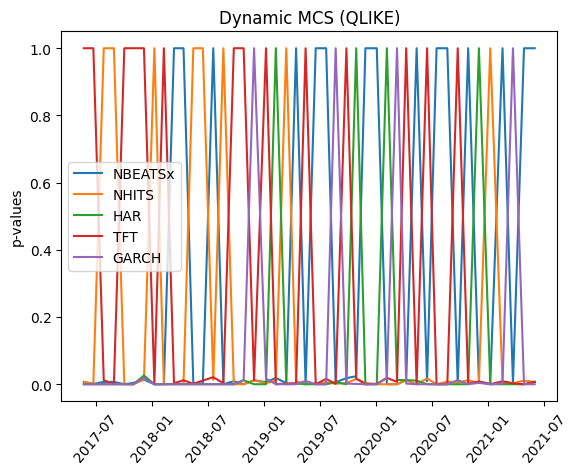

In [97]:
NHITS_residuals=(Actuals/NHITS)-np.log(Actuals/NHITS)-1
NBEATSx_residuals=(Actuals/NBEATSx)-np.log(Actuals/NBEATSx)-1
TFT_residuals=(Actuals/TFT)-np.log(Actuals/TFT)-1
HAR_residuals=(Actuals/HAR)-np.log(Actuals/HAR)-1
GARCH_residuals=(Actuals/GARCH)-np.log(Actuals/GARCH)-1

NHITS_residuals=NHITS_residuals.sum(axis=1)/len(Actuals.columns)
NBEATSx_residuals=NBEATSx_residuals.sum(axis=1)/len(Actuals.columns)
TFT_residuals=TFT_residuals.sum(axis=1)/len(Actuals.columns)
HAR_residuals=HAR_residuals.sum(axis=1)/len(Actuals.columns)
GARCH_residuals=GARCH_residuals.sum(axis=1)/len(Actuals.columns)

losses = pd.DataFrame({'NHITS':NHITS_residuals,
              'NBEATSx': NBEATSx_residuals,
              'TFT': TFT_residuals,
              'HAR': HAR_residuals,
              'GARCH': GARCH_residuals})

losses=losses.iloc[:len(losses)-len(losses)%22]
periods=[]
for i in range(int(len(losses)/22)+1):
  periods.append(22*i)

Dynamic_pvalues=np.zeros([int(len(losses)/22),5])
for i in range(len(periods)-1):
  mcs = MCS(losses.iloc[periods[i]:periods[i+1]], size=0.05, method="R", block_size=len(losses))
  mcs.compute()
  Dynamic_pvalues[i,:]=mcs.pvalues.sort_values('Model name').values.reshape(5)

Indexes=np.zeros([int(len(losses)/22),1])
for i in range(len(periods)-1):
  df2=losses.iloc[periods[i]:periods[i+1]]
  Indexes[i,:]=df2.index.values[-1]
Indexes=Indexes.reshape(len(Dynamic_pvalues)).astype('datetime64[ns]')
Data= {'GARCH':Dynamic_pvalues[:,0],
       'HAR':Dynamic_pvalues[:,1],
       'NBEATSx':Dynamic_pvalues[:,2],
       'NHITS':Dynamic_pvalues[:,3],
       'TFT':Dynamic_pvalues[:,4]

}

Pvalues=pd.DataFrame(data=Data, index=Indexes )

plt.plot(Pvalues.index,Pvalues["NBEATSx"])
plt.plot(Pvalues.index,Pvalues["NHITS"])
plt.plot(Pvalues.index,Pvalues["HAR"])
plt.plot(Pvalues.index,Pvalues["TFT"])
plt.plot(Pvalues.index,Pvalues["GARCH"])
plt.ylabel("p-values")
plt.title("Dynamic MCS (QLIKE)")
plt.legend(['NBEATSx', 'NHITS', 'HAR', 'TFT', 'GARCH'])
plt.xticks(rotation=50)
plt.show()

# MCS test with MAPE

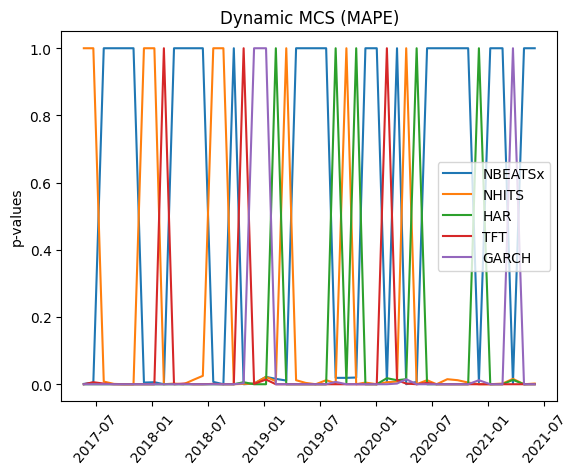

In [98]:
NHITS_residuals=abs(Actuals-NHITS)/Actuals
NBEATSx_residuals=abs(Actuals-NBEATSx)/Actuals
TFT_residuals=abs(Actuals-TFT)/Actuals
HAR_residuals=abs(Actuals-HAR)/Actuals
GARCH_residuals=abs(Actuals-GARCH)/Actuals

NHITS_residuals=NHITS_residuals.sum(axis=1)/len(Actuals.columns)
NBEATSx_residuals=NBEATSx_residuals.sum(axis=1)/len(Actuals.columns)
TFT_residuals=TFT_residuals.sum(axis=1)/len(Actuals.columns)
HAR_residuals=HAR_residuals.sum(axis=1)/len(Actuals.columns)
GARCH_residuals=GARCH_residuals.sum(axis=1)/len(Actuals.columns)

losses = pd.DataFrame({'NHITS':NHITS_residuals,
              'NBEATSx': NBEATSx_residuals,
              'TFT': TFT_residuals,
              'HAR': HAR_residuals,
              'GARCH': GARCH_residuals})

losses=losses.iloc[:len(losses)-len(losses)%22]
periods=[]
for i in range(int(len(losses)/22)+1):
  periods.append(22*i)

Dynamic_pvalues=np.zeros([int(len(losses)/22),5])
for i in range(len(periods)-1):
  mcs = MCS(losses.iloc[periods[i]:periods[i+1]], size=0.05, method="R", block_size=len(losses))
  mcs.compute()
  Dynamic_pvalues[i,:]=mcs.pvalues.sort_values('Model name').values.reshape(5)

Indexes=np.zeros([int(len(losses)/22),1])
for i in range(len(periods)-1):
  df2=losses.iloc[periods[i]:periods[i+1]]
  Indexes[i,:]=df2.index.values[-1]
Indexes=Indexes.reshape(len(Dynamic_pvalues)).astype('datetime64[ns]')
Data= {'GARCH':Dynamic_pvalues[:,0],
       'HAR':Dynamic_pvalues[:,1],
       'NBEATSx':Dynamic_pvalues[:,2],
       'NHITS':Dynamic_pvalues[:,3],
       'TFT':Dynamic_pvalues[:,4]

}

Pvalues=pd.DataFrame(data=Data, index=Indexes )

plt.plot(Pvalues.index,Pvalues["NBEATSx"])
plt.plot(Pvalues.index,Pvalues["NHITS"])
plt.plot(Pvalues.index,Pvalues["HAR"])
plt.plot(Pvalues.index,Pvalues["TFT"])
plt.plot(Pvalues.index,Pvalues["GARCH"])
plt.ylabel("p-values")
plt.title("Dynamic MCS (MAPE)")
plt.legend(['NBEATSx', 'NHITS', 'HAR', 'TFT', 'GARCH'])
plt.xticks(rotation=50)
plt.show()